## Import Libraries

In [8]:
%matplotlib inline
import collections
from sklearn import preprocessing
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import shutil

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

## Define Functions

In [9]:


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


## Import DataSet

In [58]:
preprocess = True

filename_read = os.path.join("CSC215_P2_Stock_Price.csv")
df = pd.read_csv(filename_read,na_values=['NA','?']) # No NA Values found
df.drop(['Date','Adj_Close'],axis=1,inplace=True)
df.head()

,Open,High,Low,Close,Volume
0,3.812500,4.156250,3.812500,4.125000,3675600
1,4.125000,4.125000,4.000000,4.015625,1077600
2,4.000000,4.031250,3.953125,4.000000,437200
3,4.000000,4.000000,3.843750,3.843750,1883600
4,3.734375,3.734375,3.390625,3.390625,7931600


In [62]:
df['Volume'].unique

<bound method Series.unique of 0        3675600
1        1077600
2         437200
3        1883600
4        7931600
5       11486800
6       13136800
7        6349600
8        7181200
9       13904800
10       5280800
11       6590000
12       8546400
13       6874400
14       2626000
15       2992000
16       2896000
17       4662400
18       4558800
19       3815200
20       4635600
21       5321200
22       4085200
23       3539200
24       4310000
25       2684400
26       4164400
27       3610400
28       1710800
29       1435600
          ...   
4362     2185100
4363     1467900
4364     1297200
4365     1249500
4366     1469600
4367      962800
4368      723200
4369      976900
4370      980400
4371      982100
4372      673800
4373     1294500
4374      898400
4375      943600
4376      981500
4377     1134600
4378     1089000
4379     1433200
4380     2074000
4381     1269400
4382     1206400
4383     1050200
4384     1366000
4385      929200
4386     1091400
4387      950000


## Performing Normalization

In [27]:
encode_numeric_zscore(df, 'Open', mean=None, sd=None)
encode_numeric_zscore(df, 'High', mean=None, sd=None)
encode_numeric_zscore(df, 'Low', mean=None, sd=None)
encode_numeric_zscore(df, 'Volume', mean=None, sd=None)
df

,Open,High,Low,Close,Volume
0,-0.894209,-0.885022,-0.892306,4.125000,1.104812
1,-0.883762,-0.886056,-0.885975,4.015625,-0.497301
2,-0.887941,-0.889159,-0.887558,4.000000,-0.892217
3,-0.887941,-0.890194,-0.891251,3.843750,-0.000263
4,-0.896820,-0.898986,-0.906551,3.390625,3.729366
5,-0.904655,-0.900020,-0.904969,3.437500,5.921757
6,-0.903610,-0.904158,-0.916576,3.500000,6.939265
7,-0.905700,-0.904675,-0.904441,3.484375,2.753792
8,-0.904655,-0.903641,-0.903913,3.578125,3.266616
9,-0.901521,-0.896400,-0.899693,3.609375,7.412869


## Fully Connected Neural Network Model

### Activation - Relu and Optimizer - Adam

In [34]:
x,y = to_xy(df,"Close")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_train shape:",y_test.shape)

x_train shape: (3074, 4)
x_test shape: (1318, 4)
y_train shape: (3074,)
y_train shape: (1318,)


Train on 3074 samples, validate on 1318 samples
Epoch 1/1000
3074/3074 - 1s - loss: 1853.3326 - val_loss: 1757.4398
Epoch 2/1000
3074/3074 - 0s - loss: 1848.1066 - val_loss: 1751.0085
Epoch 3/1000
3074/3074 - 0s - loss: 1840.9818 - val_loss: 1742.6568
Epoch 4/1000
3074/3074 - 0s - loss: 1831.9415 - val_loss: 1731.8254
Epoch 5/1000
3074/3074 - 0s - loss: 1815.4685 - val_loss: 1700.1461
Epoch 6/1000
3074/3074 - 0s - loss: 1742.1235 - val_loss: 1599.8674
Epoch 7/1000
3074/3074 - 0s - loss: 1639.5384 - val_loss: 1498.7464
Epoch 8/1000
3074/3074 - 0s - loss: 1532.5636 - val_loss: 1392.5251
Epoch 9/1000
3074/3074 - 0s - loss: 1413.3529 - val_loss: 1278.2280
Epoch 10/1000
3074/3074 - 0s - loss: 1295.5206 - val_loss: 1157.9647
Epoch 11/1000
3074/3074 - 0s - loss: 1163.7703 - val_loss: 1028.6878
Epoch 12/1000
3074/3074 - 0s - loss: 1016.5148 - val_loss: 880.2326
Epoch 13/1000
3074/3074 - 0s - loss: 855.5264 - val_loss: 716.7006
Epoch 14/1000
3074/3074 - 0s - loss: 678.2869 - val_loss: 549.3034


Epoch 128/1000
3074/3074 - 0s - loss: 0.2671 - val_loss: 0.2747
Epoch 129/1000
3074/3074 - 0s - loss: 0.2647 - val_loss: 0.2693
Epoch 130/1000
3074/3074 - 0s - loss: 0.2566 - val_loss: 0.2646
Epoch 131/1000
3074/3074 - 0s - loss: 0.2533 - val_loss: 0.2611
Epoch 132/1000
3074/3074 - 0s - loss: 0.2535 - val_loss: 0.2568
Epoch 133/1000
3074/3074 - 0s - loss: 0.2476 - val_loss: 0.2527
Epoch 134/1000
3074/3074 - 0s - loss: 0.2451 - val_loss: 0.2490
Epoch 135/1000
3074/3074 - 0s - loss: 0.2412 - val_loss: 0.2456
Epoch 136/1000
3074/3074 - 0s - loss: 0.2387 - val_loss: 0.2414
Epoch 137/1000
3074/3074 - 0s - loss: 0.2363 - val_loss: 0.2380
Epoch 138/1000
3074/3074 - 0s - loss: 0.2349 - val_loss: 0.2347
Epoch 139/1000
3074/3074 - 0s - loss: 0.2341 - val_loss: 0.2312
Epoch 140/1000
3074/3074 - 0s - loss: 0.2297 - val_loss: 0.2284
Epoch 141/1000
3074/3074 - 0s - loss: 0.2278 - val_loss: 0.2260
Epoch 142/1000
3074/3074 - 0s - loss: 0.2269 - val_loss: 0.2240
Epoch 143/1000
3074/3074 - 0s - loss: 0.

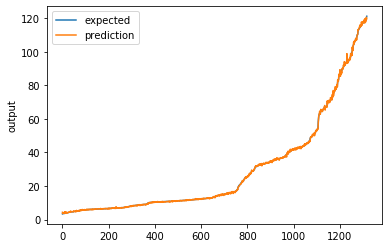

In [39]:

model = Sequential()

model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(5,activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')  

# patience: number of epochs with no improvement after which training will be stopped

# The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)

model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000) 

pred= model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
chart_regression(pred.flatten(),y_test)

### Activation - Relu and Optimizer - SGD

Train on 3074 samples, validate on 1318 samples
Epoch 1/1000
3074/3074 - 1s - loss: 389.4300 - val_loss: 314.4379
Epoch 2/1000
3074/3074 - 0s - loss: 191.5835 - val_loss: 449.9016
Epoch 3/1000
3074/3074 - 0s - loss: 166.8056 - val_loss: 1381.3255
Epoch 4/1000
3074/3074 - 0s - loss: 452.9890 - val_loss: 9.3468
Epoch 5/1000
3074/3074 - 0s - loss: 100.3973 - val_loss: 21.0677
Epoch 6/1000
3074/3074 - 0s - loss: 113.2029 - val_loss: 386.9268
Epoch 7/1000
3074/3074 - 0s - loss: 141.1747 - val_loss: 673.3226
Epoch 8/1000
3074/3074 - 0s - loss: 111.2368 - val_loss: 3.1262
Epoch 9/1000
3074/3074 - 0s - loss: 101.0864 - val_loss: 6.0770
Epoch 10/1000
3074/3074 - 0s - loss: 32.9130 - val_loss: 2.2467
Epoch 11/1000
3074/3074 - 0s - loss: 87.7395 - val_loss: 1.4630
Epoch 12/1000
3074/3074 - 0s - loss: 42.0814 - val_loss: 471.8939
Epoch 13/1000
3074/3074 - 0s - loss: 120.5621 - val_loss: 210.8353
Epoch 14/1000
3074/3074 - 0s - loss: 48.6747 - val_loss: 1764.8990
Epoch 15/1000
3074/3074 - 0s - loss:

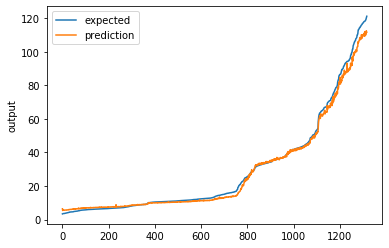

In [55]:

model = Sequential()

model.add(Dense(5, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1,activation='relu'))
model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')  

# patience: number of epochs with no improvement after which training will be stopped

# The test set is checked during training to monitor progress for early stopping but is never used for gradient descent (model training)

model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=128, callbacks=[monitor], verbose=2, epochs=1000) 

pred= model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
chart_regression(pred.flatten(),y_test)